In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [4]:
data = pd.read_csv('more_data_fixed.csv')

Check how many data points that we scraped have an aggregate user score listed

In [5]:
len(data[data.user_score != 'tbd'])

1331

We have 1331 data points out of 2503 without user scores (all albums have critic score).  Going to try linear regression 
on the subset of 1331 data points with user scores and see how we do.  If it looks like more 
data is needed, we can either scrape more, or stick with critic score as target variable

In [206]:
data_sub = data[data.user_score != 'tbd']
data_sub.user_score = data_sub.user_score.astype(dtype='float64', copy=False)*10

In [207]:
data_sub.reset_index(drop=True,inplace=True)

In [211]:
labels = data_sub[['critic_score', 'user_score']]

I'm leaving the critic and user score in my features list for now so that they are included when I look at distributions, pairplots, etc.

In [212]:
features = data_sub[['critic_score', 'user_score','release_month','day_of_week_release', 'num_tracks', 'artist_monthly_listeners', \
                       'album_length_seconds', 'avg_track_length_seconds', 'percent_explicit', 'danceability_avg', \
                      'energy_avg', 'loudness_avg', 'speechiness_avg', 'acousticness_avg', 'instrumentalness_avg', \
                      'liveness_avg', 'valence_avg', 'tempo_avg']]

Plot histograms of our features and targets to visualize distributions

In [214]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331 entries, 0 to 1330
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   critic_score              1331 non-null   int64  
 1   user_score                1331 non-null   float64
 2   release_month             1331 non-null   int64  
 3   day_of_week_release       1331 non-null   int64  
 4   num_tracks                1331 non-null   int64  
 5   artist_monthly_listeners  1331 non-null   int64  
 6   album_length_seconds      1331 non-null   float64
 7   avg_track_length_seconds  1331 non-null   float64
 8   percent_explicit          1331 non-null   float64
 9   danceability_avg          1331 non-null   float64
 10  energy_avg                1331 non-null   float64
 11  loudness_avg              1331 non-null   float64
 12  speechiness_avg           1331 non-null   float64
 13  acousticness_avg          1331 non-null   float64
 14  instrume

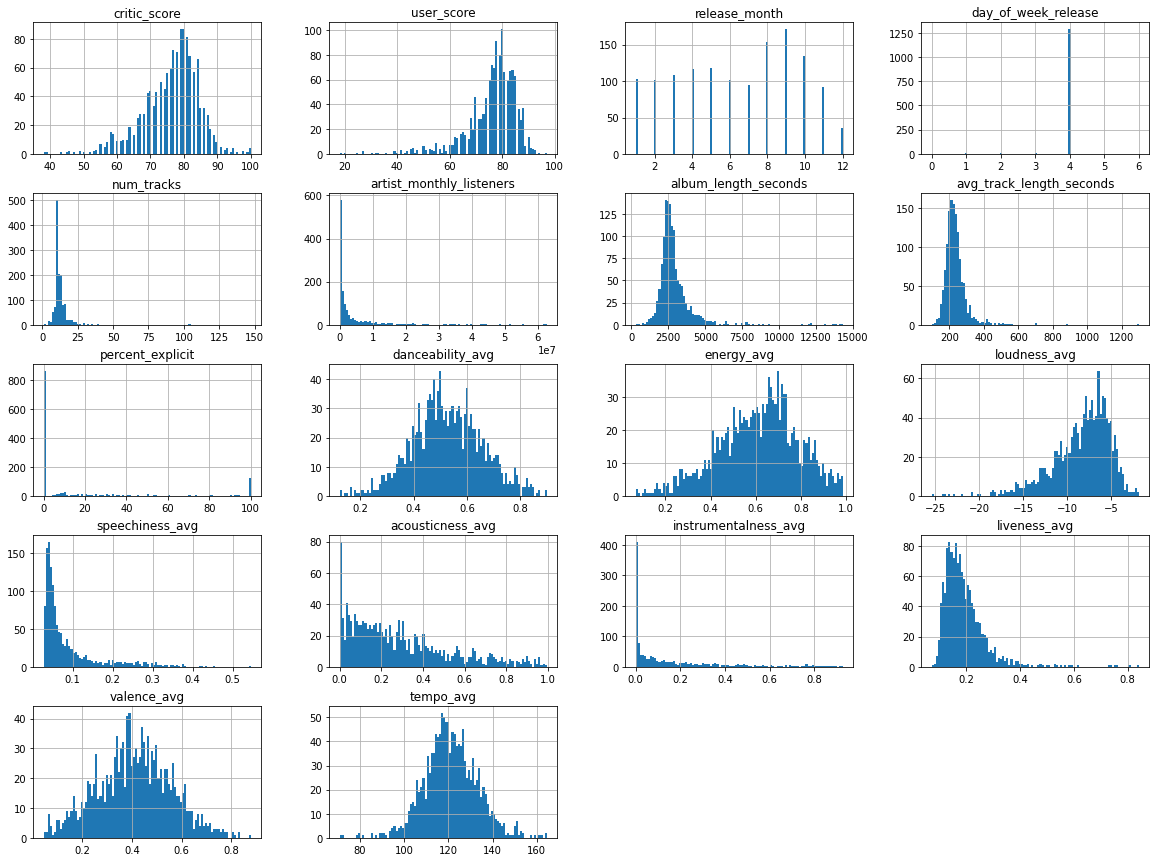

In [216]:
%matplotlib inline
features.hist(bins=100, figsize=(20,15))
plt.show()

A few takeaways from glancing at these distributions:
- Artist monthly listeners and instrumentalness are both heavily right skewed (specifically, a lot of albums seem to be at exactly zero for average instrumentalness).  This means that most of the artists on metacritic are ones who haven't "made it" yet in the industry, and most albums have vocals throughout, or if not then they may have short instrumental interludes 
- Based on the fact that most albums are either 0% or 100% explicit, it might make sense to treat this as a categorical variable with 3 bins (None explicit, some explicit, and all explicit)
- Almost all albums are released on Fridays, so that feature will likely not be helpful to us
- 
- Not a lot of music is released in December during the holiday season.  August, September, and October are the three busiest months though, which makes sense intuitively: big artists on major labels want to take advantage of the holiday retail spike, many artists want to be in contention for end of year lists and awards show nominations (for example, the cutoff for Grammy eligibility is Sept. 30th). Interesting data, but unclear how it might affect our regression- we could look at August-October as one "group" to see if critic scores change when the writers are busier, or if albums released in December tend to be underappreciated as writers focus on their "Best Of" lists.

In [3]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
# ax1.scatter(features.artist_monthly_listeners, features.critic_score);
# ax2.scatter(np.log(features.artist_monthly_listeners), features.critic_score);
# ax3.scatter(np.log(features.artist_monthly_listeners), features.user_score);

x = np.log(features.artist_monthly_listeners)
y = features.critic_score
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

NameError: name 'features' is not defined

I then plotted the target variable against monthly listeners, as well as the log of monthly listeners to see if it might make a relationship more apparent.

It seems to suggest that artists with exponentially larger followings are at higher risk of getting panned (receiving particularly low scores).  For example, of artists with less than 100,000 monthly listeners, only 1 received a critic score below a 60.  

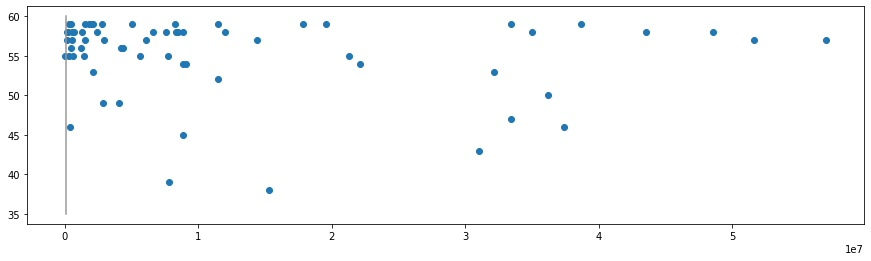

In [257]:
features[features.critic_score < 60].sort_values('artist_monthly_listeners').head(50)
fig, ax = plt.subplots(figsize=(15,4))
ax.scatter(features[features.critic_score < 60]['artist_monthly_listeners'],features[features.critic_score < 60]['critic_score'] )
ax.plot([100000, 100000], [35, 60], color = '#999999')

In [265]:
#Add log of monthly listeners as a column to potentially use later on
features['log_monthly_listeners'] = np.log(features['artist_monthly_listeners'])

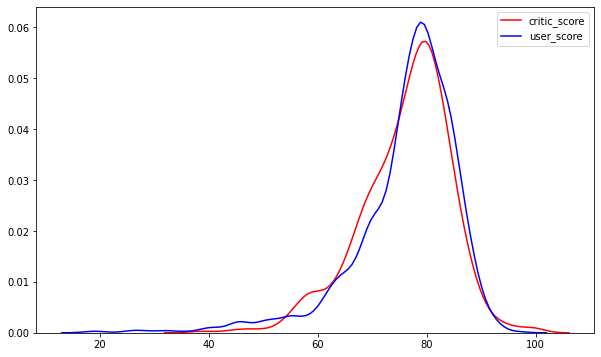

In [261]:
fig, ax = plt.subplots(figsize=(10,6))
kde = sns.kdeplot(features.critic_score, shade=False, color='r')
kde = sns.kdeplot(features.user_score, shade=False, color='b')


- We can see that users are more likely to give very harsh scores than critics anywhere from 20-55
- Critics are more likely to hand out scores from 55-75
- Users are slightly more likely to hand out positive scores from 75-90
- Critics are more likely to give out "perfect" scores from 90-100

For well known, critically acclaimed albums, there are way more users rating the album, so it is more difficult
to achieve a consensus that is higher than a 90/100.  For example, metacritic's top album of the year, Fiona Apple's
Fetch the Bolt Cutters, has a 98 critic score on 28 critic reviews as opposed to an 81 user score on 1,076 reviews

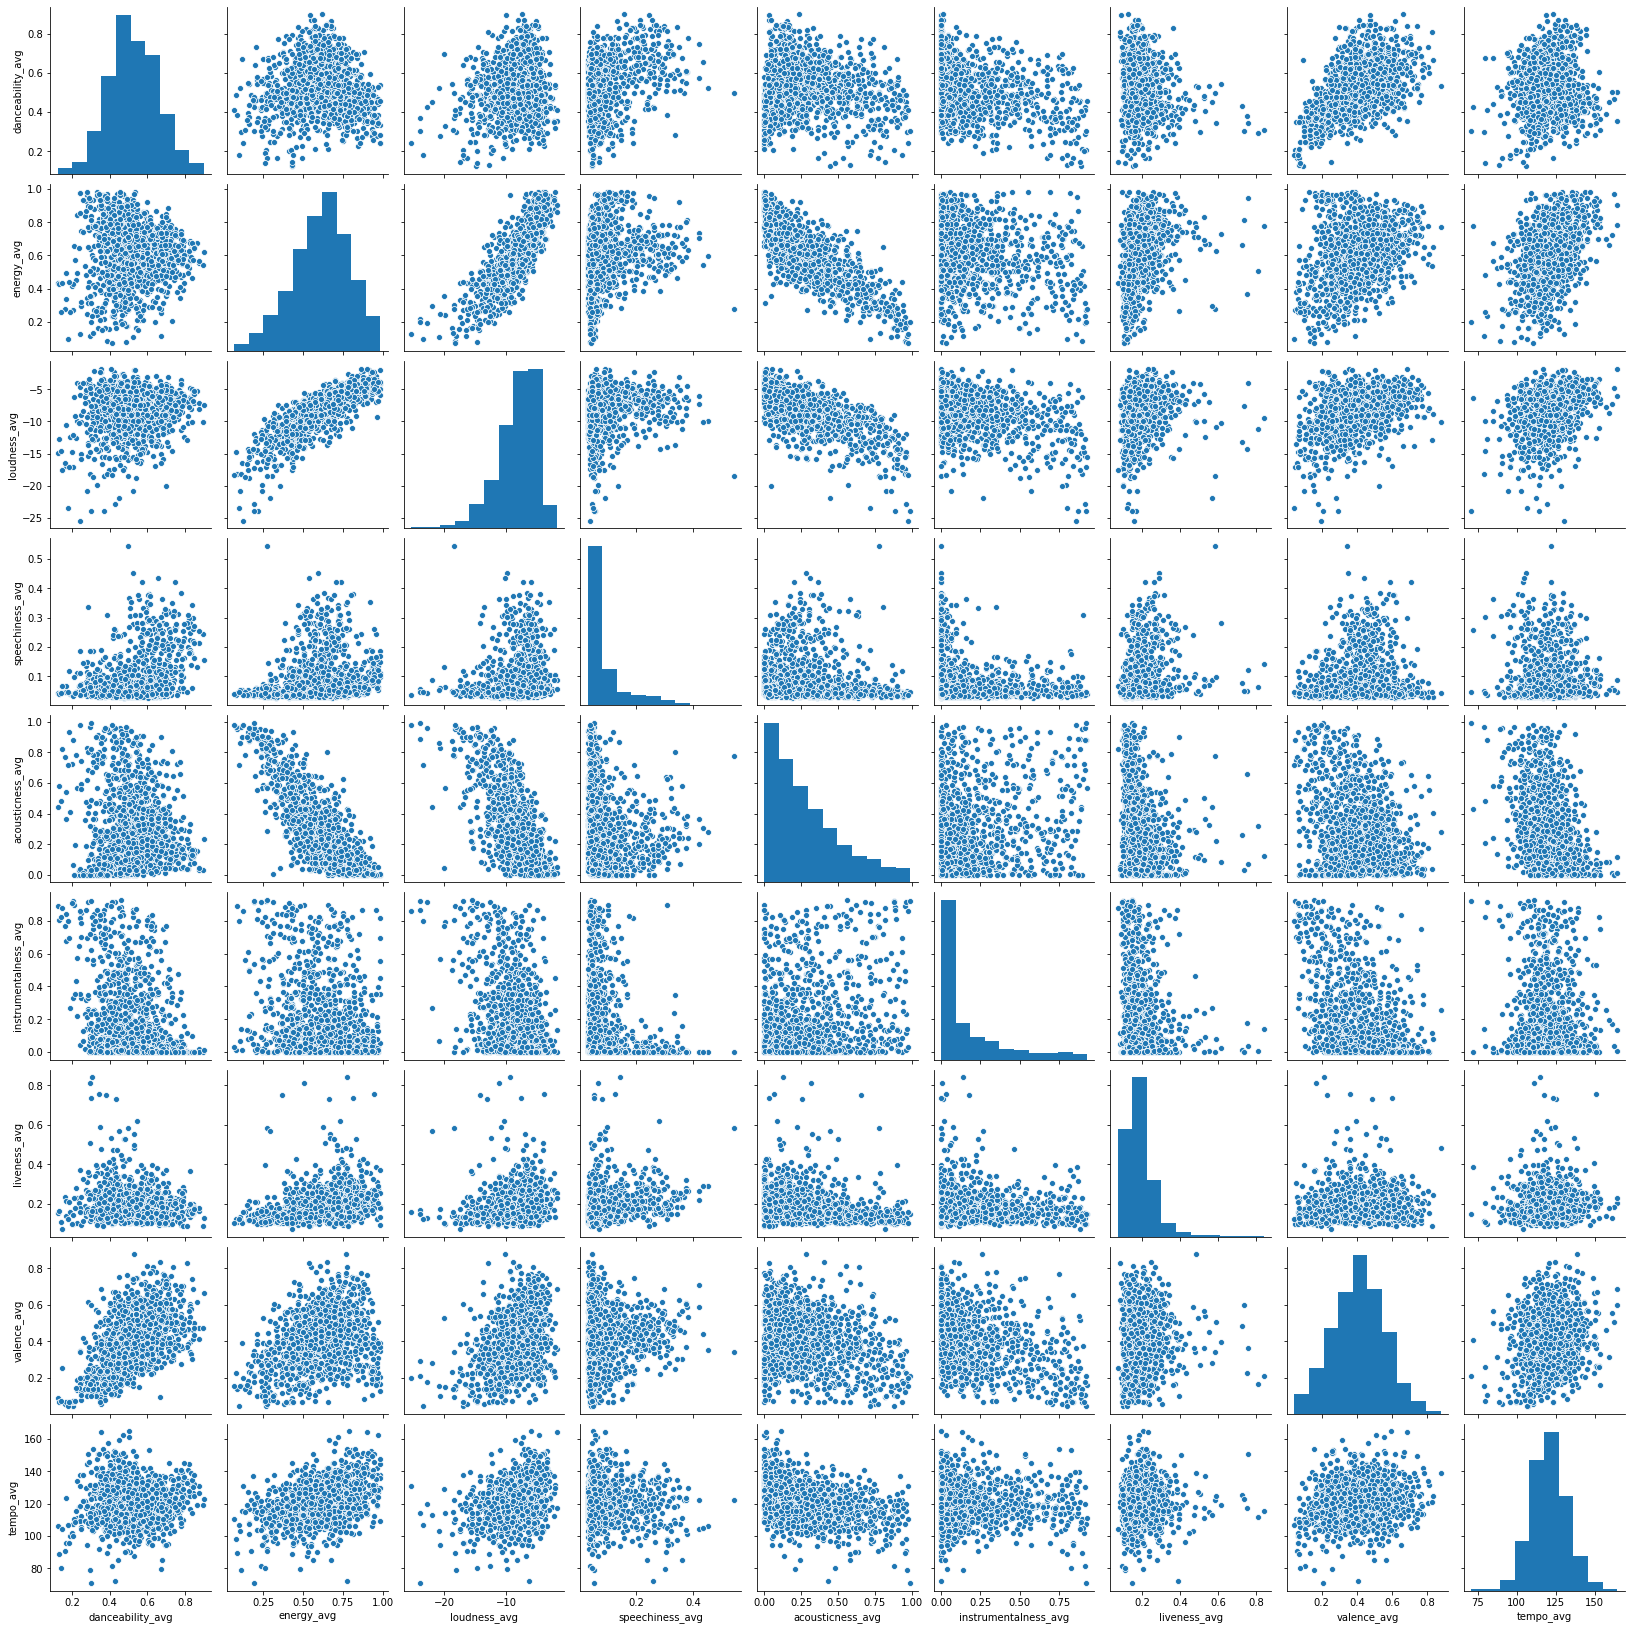

In [262]:
sns.pairplot(features[['danceability_avg', 'energy_avg', 'loudness_avg', 'speechiness_avg', 'acousticness_avg', 'instrumentalness_avg', \
                      'liveness_avg', 'valence_avg', 'tempo_avg']])

Next I looked at a pairplot of Spotify's audio features because I suspected that some of their features may be correlated based on the descriptions. That theory was confirmed:
- danceability and valence (a measure of how happy the music is) are positively correlated
- loudness and energy are positively correlated
- energy and speechiness have an interesting correlation, where there seem to be two separate branches.  I'm curious if this indicates two different "categories" that follow different trends
- energy and loudness are both negatively correlated with acousticness


<AxesSubplot:>

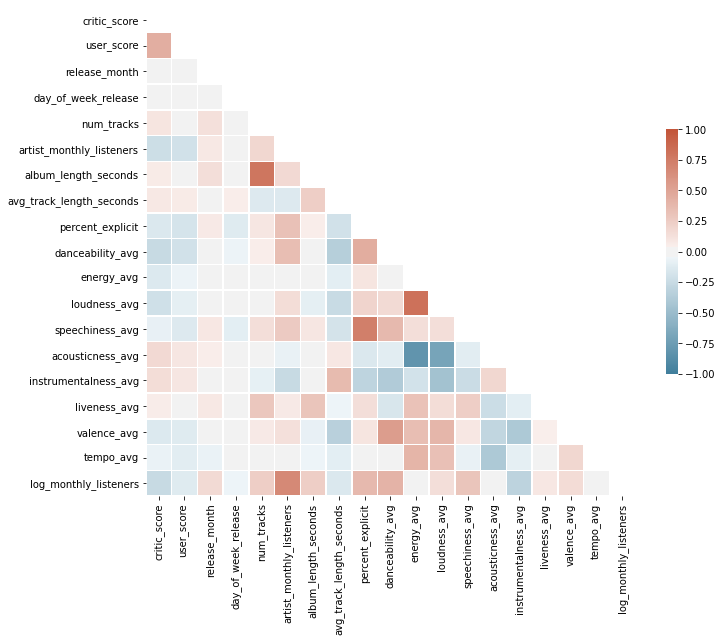

In [266]:
corr = features.corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
fig, ax = plt. subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, \
           linewidths=.5, cbar_kws={'shrink':.5})

Variables with most collinearity:
- Album length and number of tracks
- Loudness and Energy
- Speechiness and Percent Explicit
- Valence and Danceability
- Acousticness and Energy
- Acousticness and Loudness

- It looks like our log transform of monthly listeners is so far the best single predictor of critic score (not counting our other target variable, user score)
- Acoustic and instrumental tracks seem to be received better than loud, danceable tricks.  It remains to be seen if that is due to the type of music, or just because the bigger, more commercial artists tend to release dancier albums


In [267]:
corr.critic_score.sort_values()

log_monthly_listeners      -0.255542
danceability_avg           -0.250707
artist_monthly_listeners   -0.219186
loudness_avg               -0.207321
percent_explicit           -0.146813
energy_avg                 -0.136004
valence_avg                -0.135906
speechiness_avg            -0.070575
tempo_avg                  -0.057713
release_month              -0.032166
day_of_week_release        -0.001584
liveness_avg                0.060251
album_length_seconds        0.070162
avg_track_length_seconds    0.082142
num_tracks                  0.107138
instrumentalness_avg        0.151711
acousticness_avg            0.178071
user_score                  0.440682
critic_score                1.000000
Name: critic_score, dtype: float64

In [268]:
corr.user_score.sort_values()

danceability_avg           -0.200782
artist_monthly_listeners   -0.196571
percent_explicit           -0.176465
speechiness_avg            -0.129161
valence_avg                -0.120781
log_monthly_listeners      -0.118608
tempo_avg                  -0.106885
loudness_avg               -0.093297
energy_avg                 -0.048042
album_length_seconds        0.005352
num_tracks                  0.005462
release_month               0.009416
liveness_avg                0.012792
day_of_week_release         0.019649
avg_track_length_seconds    0.063680
instrumentalness_avg        0.094793
acousticness_avg            0.097500
critic_score                0.440682
user_score                  1.000000
Name: user_score, dtype: float64

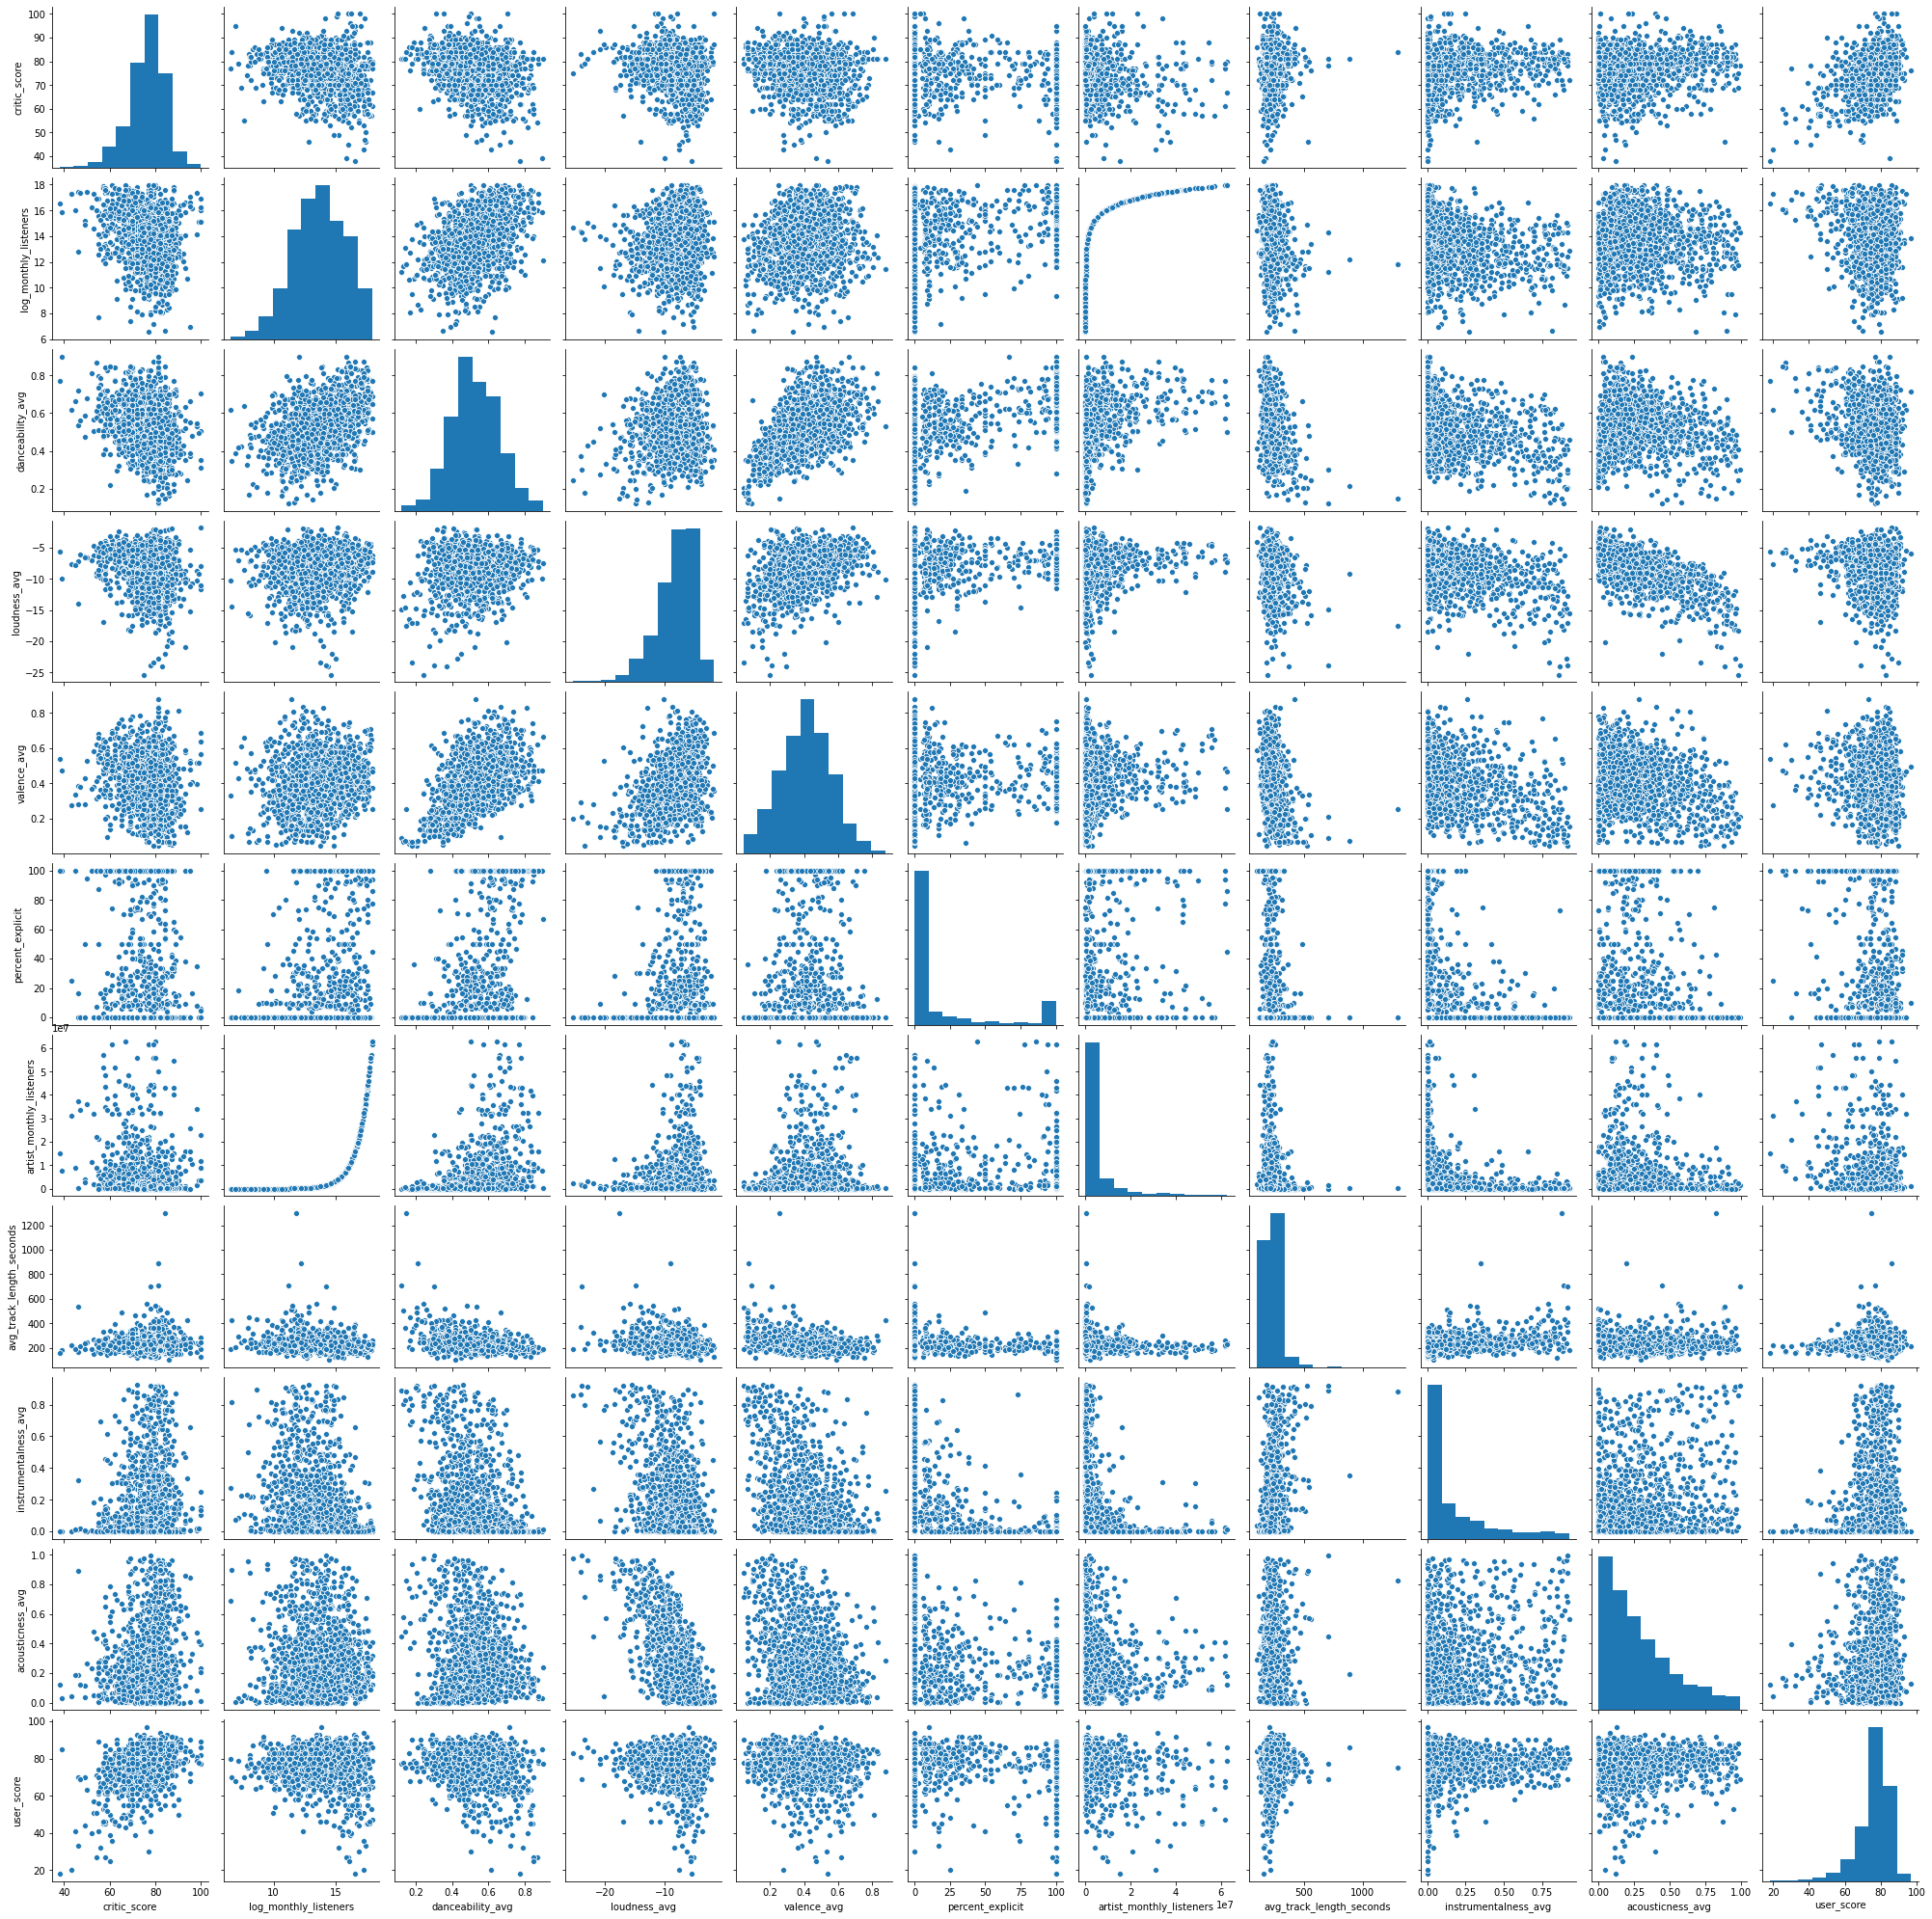

In [274]:
sns.pairplot(features[['critic_score', 'log_monthly_listeners', 'danceability_avg', 'loudness_avg', 'valence_avg', \
                      'percent_explicit', 'artist_monthly_listeners', 'avg_track_length_seconds', \
                      'instrumentalness_avg', 'acousticness_avg', 'user_score']])

In [366]:
#864 albums with no explicit tracks, receive a 76.91 on average
features[features.percent_explicit == 0]['critic_score'].mean()

76.91087962962963

In [367]:
#346 albums with some, but not all, explicit tracks receive a 75.48 on average
features[(features.percent_explicit > 0) & (features.percent_explicit <99)]['critic_score'].mean()

75.47976878612717

In [368]:
#121 albums with all tracks explicit receive a 72.91 on average
features[features.percent_explicit > 99]['critic_score'].mean()

72.9090909090909

Since a large majority of albums have no explicit tracks, and there's a significant portion with 100% explicit tracks (which receive almost 4 points less from critics on average, I am creating a categorical variable with 3 bins

In [286]:
features['explicit_cat'] = features['percent_explicit'].apply(lambda x: 1 if ((x > 0) & (x<100)) else x)
features['explicit_cat'] = features['explicit_cat'].apply(lambda x: 2 if x > 1 else x)

Split the training and test sets, stratified by our 3 explicitness bins to ensure all three buckets are represented in both sets.

In [287]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(features, features['explicit_cat']):
    strat_train_set = features.loc[train_index]
    strat_test_set = features.loc[test_index]

In [288]:
train_set = strat_train_set.copy()
train_set_labels = strat_train_set[['critic_score', 'user_score']].copy()

test_set = strat_test_set.copy()
test_set_labels = strat_test_set[['critic_score', 'user_score']].copy()

In [289]:
train_set_num = train_set.drop(columns=['release_month', 'day_of_week_release', 'explicit_cat'])
train_set_cat = train_set[['release_month', 'explicit_cat']]

In [290]:
energy_ix, acoustic_ix, length_ix, instrumental_ix = 8, 11, 4, 12

In [377]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_long_instrumentals = True):
        self.add_long_instrumentals = add_long_instrumentals
    def fit(self, X, y=None):
        return self #Nothing else to do
    def transform(self, X, y=None):
        X_vals = X.values
        energetic_acoustic = X_vals[:, acoustic_ix] - X_vals[:, energy_ix]
        if self.add_long_instrumentals:
            long_instrumentals = X_vals[:, length_ix] * X_vals[:, instrumental_ix]
            return np.c_[X_vals, energetic_acoustic, long_instrumentals]
        else:
            return np.c_[X_vals, energetic_acoustic]

Pipeline for numerical features: 
1) add any combined attributes \
2) scale the features

In [378]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('attribute_adder', CombinedAttributesAdder(add_long_instrumentals=True)),
        ('standard_scaler', StandardScaler())
])

In [379]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
num_attribs = list(train_set_num)
cat_attribs = ['release_month', 'explicit_cat']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

train_set_pipeline = full_pipeline.fit_transform(train_set)
train_set_prepared = pd.DataFrame(data=train_set_pipeline, columns = num_attribs+ \
                                 ['energetic_acoustic', 'long_instrumentals', \
                                  'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', \
                                  'aug', 'sept', 'oct', 'nov', 'dec', 'none_explicit', \
                                 'some_explicit', 'all_explicit'])

To avoid dummy variable trap: 
- remove 'Dec' column, and 'all_explicit' columnso there are (n-1) dummy vars. for each 
    categorical with n categories
- This is to prevent multicollinearity (we already capture the case where Dec = 1.0 when 
    all 11 other months are "0", there's no need to have a column for it

In [380]:
train_set_prepared.drop(columns=['dec', 'all_explicit', 'percent_explicit', \
                                'energetic_acoustic', 'long_instrumentals'], inplace=True)
train_set_prepared.drop(columns=['critic_score', 'user_score'], inplace=True)

In [381]:
train_set_prepared.describe()

,num_tracks,artist_monthly_listeners,album_length_seconds,avg_track_length_seconds,danceability_avg,energy_avg,loudness_avg,speechiness_avg,acousticness_avg,instrumentalness_avg,...,apr,may,jun,jul,aug,sept,oct,nov,none_explicit,some_explicit
count,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,...,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,2.010714e-16,1.168656e-17,-8.639705e-17,3.818870e-16,1.732115e-17,-4.424197e-16,-3.153284e-16,1.531774e-16,-9.690974e-17,6.865853e-17,...,0.092105,0.077068,0.083647,0.069549,0.115602,0.122180,0.105263,0.071429,0.649436,0.259398
std,1.000470e+00,1.000470e+00,1.000470e+00,1.000470e+00,1.000470e+00,1.000470e+00,1.000470e+00,1.000470e+00,1.000470e+00,1.000470e+00,...,0.289310,0.266824,0.276987,0.254505,0.319897,0.327648,0.307037,0.257660,0.477371,0.438511
min,-1.246831e+00,-5.037599e-01,-1.607156e+00,-2.201406e+00,-3.131616e+00,-3.025628e+00,-5.268063e+00,-7.853405e-01,-1.201978e+00,-7.371624e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.534788e-01,-4.815620e-01,-4.733160e-01,-5.482966e-01,-6.395224e-01,-6.292179e-01,-5.035054e-01,-6.155053e-01,-7.923978e-01,-7.242652e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.301407e-01,-4.051317e-01,-2.210689e-01,-1.601221e-01,-4.118765e-02,9.593690e-02,1.810871e-01,-4.326058e-01,-2.613051e-01,-4.577239e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,9.319751e-02,-6.194043e-02,1.578368e-01,3.338116e-01,6.810740e-01,6.582151e-01,7.041457e-01,1.324228e-01,5.337627e-01,3.461991e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.494519e+01,6.064652e+00,8.432406e+00,1.047239e+01,2.847859e+00,2.112774e+00,2.003739e+00,5.981939e+00,2.958772e+00,3.252359e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [372]:
X.corr()

,num_tracks,artist_monthly_listeners,album_length_seconds,avg_track_length_seconds,danceability_avg,energy_avg,loudness_avg,speechiness_avg,acousticness_avg,instrumentalness_avg,...,apr,may,jun,jul,aug,sept,oct,nov,none_explicit,some_explicit
num_tracks,1.000000,0.192829,0.803096,-0.103998,0.030420,0.045130,-0.026317,0.140914,-0.023290,-0.063161,...,-0.039999,-0.022259,-0.058653,0.007327,-0.040158,0.065855,0.030941,0.133841,-0.136880,0.122442
artist_monthly_listeners,0.192829,1.000000,0.180749,-0.127710,0.331463,-0.001716,0.137696,0.265557,-0.056516,-0.249185,...,-0.023678,0.026196,-0.037709,-0.002383,0.019904,-0.034757,-0.019787,0.076013,-0.278878,0.170535
album_length_seconds,0.803096,0.180749,1.000000,0.288883,-0.048836,-0.009678,-0.107950,0.093871,0.011012,0.009630,...,-0.053054,-0.012390,-0.069524,0.020351,-0.028483,0.071006,0.044251,0.083157,-0.092726,0.116796
avg_track_length_seconds,-0.103998,-0.127710,0.288883,1.000000,-0.344902,-0.098544,-0.245417,-0.199473,0.084232,0.367568,...,-0.010148,0.000205,0.008609,-0.014384,0.007305,0.010363,-0.002098,0.000495,0.199944,-0.091899
danceability_avg,0.030420,0.331463,-0.048836,-0.344902,1.000000,-0.017853,0.172270,0.375795,-0.112433,-0.376912,...,0.028644,0.056390,0.007565,0.039390,-0.000548,-0.041951,-0.016997,-0.018292,-0.350249,0.143186
energy_avg,0.045130,-0.001716,-0.009678,-0.098544,-0.017853,1.000000,0.821726,0.142862,-0.820002,-0.183671,...,-0.024497,-0.008253,-0.023691,-0.006946,0.017583,0.001113,0.014550,-0.044512,-0.152326,0.114140
loudness_avg,-0.026317,0.137696,-0.107950,-0.245417,0.172270,0.821726,1.000000,0.146630,-0.704680,-0.442872,...,-0.028685,0.008389,-0.002450,0.008174,0.031756,-0.036584,0.000906,-0.042243,-0.236927,0.156695
speechiness_avg,0.140914,0.265557,0.093871,-0.199473,0.375795,0.142862,0.146630,1.000000,-0.101520,-0.242006,...,0.002287,-0.022021,-0.049366,0.052205,0.043316,0.000421,0.012173,-0.014238,-0.507959,0.147872
acousticness_avg,-0.023290,-0.056516,0.011012,0.084232,-0.112433,-0.820002,-0.704680,-0.101520,1.000000,0.178981,...,-0.011283,0.027513,0.010913,0.009987,-0.031309,0.035615,0.028440,0.047332,0.168672,-0.111645
instrumentalness_avg,-0.063161,-0.249185,0.009630,0.367568,-0.376912,-0.183671,-0.442872,-0.242006,0.178981,1.000000,...,-0.046265,0.023246,0.027030,-0.043486,-0.032323,0.038318,0.018238,-0.001550,0.301042,-0.187244


In [441]:
import statsmodels.api as sm
X = train_set_prepared.copy()
# X.drop(columns=['instrumentalness_avg', 'artist_monthly_listeners', 'energy_avg','acousticness_avg'], inplace=True)
y = train_set_labels['critic_score'].tolist()


In [445]:
# y = train_set_labels['critic_score'].tolist()
model = sm.OLS(y, sm.add_constant(x_df))
fit = model.fit()
fit.summary()

/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     2.132
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           1.89e-17
Time:                        21:44:17   Log-Likelihood:                -3408.6
No. Observations:                1064   AIC:                             7491.
Df Residuals:                     727   BIC:                             9166.
Df Model:                         336                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
1                                                    13.1122     14.651      0.895      0.371     -15.651      41.875
num_tracks                                           22.3197     34.992      0.638      0.524     -46.377      91.016
artist_monthly_listeners                            -42.8742     18.378     -2.333      0.020     -78.954      -6.794
album_length_seconds                                -17.3475     24.054     -0.721      0.471     -64.572      29.877
avg_track_length_seconds                             10.0232     16.276      0.616      0.538     -21.930      41.976
danceability_avg                                     15.5940      5.259      2.965      0.003       5.269      25.919
energy_avg                                           -1.4204     10.920     -0.130      0.897     -22.859      20.018
loudness_avg                                          3.2258      7.377      0.437      0.662     -11.257      17.709
speechiness_avg                                       1.1532      3.652      0.316      0.752      -6.017       8.323
acousticness_avg                                      4.7347      5.275      0.898      0.370      -5.622      15.091
instrumentalness_avg                                -21.9383      9.189     -2.387      0.017     -39.978      -3.898
liveness_avg                                         19.8280      4.136      4.794      0.000      11.708      27.948
valence_avg                                          -7.3881      4.093     -1.805      0.071     -15.423       0.647
tempo_avg                                             1.1019      3.038      0.363      0.717      -4.862       7.065
log_monthly_listeners                                22.0508      9.977      2.210      0.027       2.464      41.638
jan                                                  19.0790      6.902      2.764      0.006       5.528      32.630
feb                                                  15.5803      6.272      2.484      0.013       3.267      27.893
mar                                                  20.8568      6.526      3.196      0.001       8.045      33.669
apr                                                  20.7847      6.385      3.255      0.001       8.249      33.320
may                                                  19.3366      6.267      3.085      0.002       7.033      31.640
jun                                                  16.3350      6.794      2.404      0.016       2.997      29.673
jul                                                  20.7046      6.351      3.260      0.001       8.237      33.172
aug                                                  18.7029      6.202      3.016      0.003       6.528      30.878
sept           

Important
- danceability_avg
- num_tracks
- liveness_avg
- log_monthly_listeners
- all the months
- none exp
- some exp

In [408]:
# poly.get_feature_names(X.columns)

In [7]:
from  sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

x_poly = poly.fit_transform(X)
x_df = pd.DataFrame(data=x_poly, columns=poly.get_feature_names(X.columns))

NameError: name 'X' is not defined

In [425]:
lin_reg = LinearRegression()
lin_reg.fit(x_df, y)

LinearRegression()

In [6]:
x_df

NameError: name 'x_df' is not defined

In [422]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
def plot_learning_curves(model, x, y):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    fig,ax=plt.subplots()
    
    ax.plot(np.sqrt(train_errors), "r-", linewidth=2, label="train")
    ax.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    ax.set_ylim((0,20))

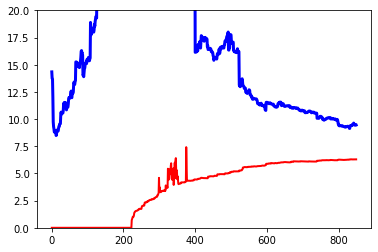

In [424]:
plot_learning_curves(lin_reg, x_df, y)

In [426]:
predictions = lin_reg.predict(x_df)
lin_mse = mean_squared_error(y, predictions)
lin_rmse1 = np.sqrt(lin_mse)
lin_rmse1

6.542219973812348

In [429]:
def validate_lasso(x, y, alpha):
    X_train, X_val, y_train, y_val = \
        train_test_split(x, y, test_size=0.2, random_state=42)
    clf = Lasso(alpha)
    clf.fit(X_train, y_train)
    val_score = clf.score(X_val, y_val)
    train_score = clf.score(X_train, y_train)
    print('\nTrain R2 score was', train_score)
    print('\nValidation R^2 score was:', val_score)

In [455]:
clf = Lasso(alpha=0.1)
clf.fit(x_df, y)
predictions = clf.predict(x_df)
residuals = predictions - y
sum(y)/len(y)

76.25375939849624

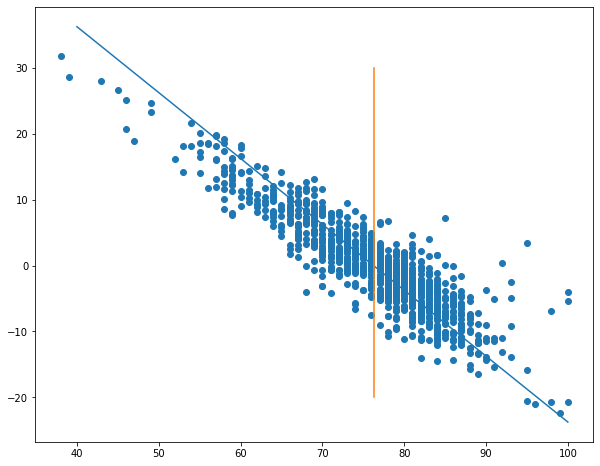

In [463]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y, residuals)
ax.plot([40, 100], [76.2537-40, 76.2537-100])
ax.plot([76.2537, 76.2537], [-20, 30])

In [446]:
for alpha in [0.01, 0.02, 0.04, 0.08, .1, .2, .4, .8, 1]:
    print(f"alpha: {alpha}")
    validate_lasso(x_df, y, alpha)

alpha: 0.01


/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260.18339067360284, tolerance: 6.004702467685076
  positive)



Train R2 score was 0.4606767219464485

Validation R^2 score was: 0.0010138270286538242
alpha: 0.02


/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386.8876052228734, tolerance: 6.004702467685076
  positive)



Train R2 score was 0.43165009661218456

Validation R^2 score was: 0.06473109967657165
alpha: 0.04


/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.6812884449464, tolerance: 6.004702467685076
  positive)



Train R2 score was 0.38187039255347754

Validation R^2 score was: 0.1169003963987223
alpha: 0.08

Train R2 score was 0.3164662297984957

Validation R^2 score was: 0.15812316164266904
alpha: 0.1

Train R2 score was 0.29079849283903036

Validation R^2 score was: 0.16337904592415187
alpha: 0.2

Train R2 score was 0.22194144793885517

Validation R^2 score was: 0.14603211012066653
alpha: 0.4

Train R2 score was 0.18600977677360497

Validation R^2 score was: 0.1350083698252339
alpha: 0.8

Train R2 score was 0.12804040656697735

Validation R^2 score was: 0.09697591993883448
alpha: 1

Train R2 score was 0.11254867036735405

Validation R^2 score was: 0.08135923512641252


Text(0, 0.5, 'Residuals')

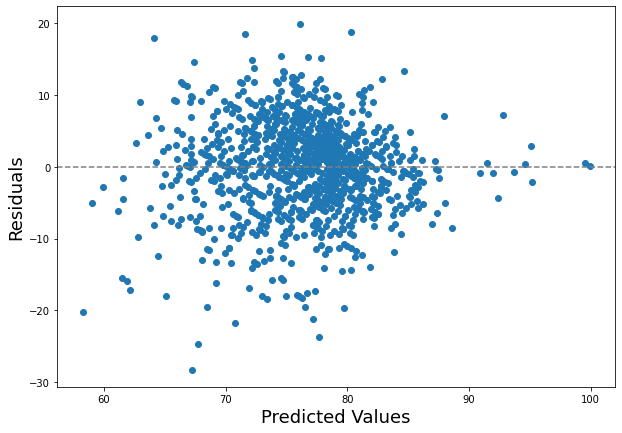

In [427]:
plt.figure(figsize=(10,7))
plt.scatter(fit.predict(), fit.resid)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18)

In [409]:
lasso_model = Lasso(alpha = .01)

In [410]:
lasso_model.fit(x_df, train_set_labels['critic_score'])

/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1294.4103261147902, tolerance: 7.497348496240602
  positive)


Lasso(alpha=0.01)

In [412]:
list(zip(x_df.columns, lasso_model.coef_))

[('1', 0.0),
 ('num_tracks', -0.0),
 ('album_length_seconds', 0.6034774041139892),
 ('avg_track_length_seconds', 0.32866670266357184),
 ('danceability_avg', -0.7211943115932574),
 ('loudness_avg', -1.8232825185573376),
 ('speechiness_avg', 0.7309232238547156),
 ('liveness_avg', 1.7054086951848044),
 ('valence_avg', 0.17692303255700334),
 ('tempo_avg', 0.2899082266568375),
 ('log_monthly_listeners', -0.24770640544083836),
 ('jan', 0.0),
 ('feb', -0.0020664365984185327),
 ('mar', 0.7837346309318023),
 ('apr', 1.9978458826477652),
 ('may', -0.0),
 ('jun', 0.0),
 ('jul', 0.006448319111053433),
 ('aug', 0.6557116278715016),
 ('sept', 0.014357902110928997),
 ('oct', -0.0),
 ('nov', -0.911333260715558),
 ('none_explicit', -0.02695911168973194),
 ('some_explicit', 0.00949391731647092),
 ('num_tracks^2', -0.06262526163273736),
 ('num_tracks album_length_seconds', 0.16224033803140914),
 ('num_tracks avg_track_length_seconds', 0.12954536044185302),
 ('num_tracks danceability_avg', 0.0),
 ('num_tr